# Suite2P Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lab_Analyses.Utilities.save_load_pickle import save_pickle, load_pickle
from Lab_Analyses.Utilities import data_utilities as utils

In [2]:
path = r'C:\Users\Jake\Desktop\Processed_data\Suite2P_data\BRAIN_test\suite2p\BRAIN_Example\plane0\F.npy'
dFoF = np.load(path)
path_s = r'C:\Users\Jake\Desktop\Processed_data\Suite2P_data\BRAIN_test\suite2p\BRAIN_Example\plane0\spks.npy'
spikes = np.load(path_s)
path2 = r'C:\Users\Jake\Desktop\Processed_data\Suite2P_data\BRAIN_test\suite2p\BRAIN_Example\plane0\iscell.npy'
iscell = np.load(path2)[:,0].astype(int)
iscell_bool = iscell.astype(bool)
dFoF_cells = dFoF[iscell_bool]
spikes_cells = spikes[iscell_bool]
dFoF_df = pd.DataFrame(dFoF_cells.T)
spikes_df = pd.DataFrame(spikes_cells.T)

In [15]:
from Lab_Analyses.Utilities.event_detection import event_detection
from Lab_Analyses.Utilities.get_dFoF import get_dFoF

fluorescence = np.array(dFoF_df)
new_dFoF = np.zeros(np.shape(fluorescence))
for i in range(fluorescence.shape[1]):
    f = fluorescence[:,i]
    d, pd, _ = get_dFoF(f, 30, 0.2, None, None)
    new_dFoF[:,i] = pd
active_traces, floored_traces, _ = event_detection(new_dFoF, 2, 10)

In [23]:
import scipy.signal as sysignal
def detection(dFoF, threshold, sampling_rate):
    LOWER_THRESH = 1
    LOWER_LIMIT = 0.2
    SEC_TO_SMOOTH = 0.5

    smooth_window = int(sampling_rate * SEC_TO_SMOOTH)
    # Make sure smooth window is odd
    if not smooth_window % 2:
        smooth_window = smooth_window + 1

    # initialize the output array
    active_traces = np.zeros(np.shape(dFoF))
    floored_traces = np.zeros(np.shape(dFoF))
    thresh_values = {"Upper Threshold": [], "Lower Threshold": [], "Artifact Limit": []}

    # Analyze each ROI
    for i in range(dFoF.shape[1]):
        roi = dFoF[:, i]
        # Estimate the noise of the traces using the mirrored below-zero trace
        below_zero = roi[roi < 0]
        noise_est = np.nanstd(np.concatenate((below_zero, -below_zero)))

        # Set threshold values
        high_thresh = noise_est * threshold
        low_thresh = noise_est * LOWER_THRESH
        # Account for movement artifacts by using largest negative deflections
        artifact_limit = np.absolute(np.percentile(below_zero, 5))
        if high_thresh < artifact_limit:
            high_thresh = artifact_limit
        if high_thresh < LOWER_LIMIT:
            high_thresh = LOWER_LIMIT

        thresh_values["Upper Threshold"].append(high_thresh)
        thresh_values["Lower Threshold"].append(low_thresh)
        thresh_values["Artifact Limit"].append(artifact_limit)

        # Generate a smoothed trace
        temp_smooth = sysignal.savgol_filter(roi, smooth_window, 2)
        # Find periods above the thrsholds
        above_low = temp_smooth > low_thresh
        above_high = temp_smooth > high_thresh

        # Fill in high portions where low threshold is not crossed
        ## E.g., dips down but not to baseline, so continuously active

        # Find edges of long-smooth above_thesh periods
        pad = np.zeros(1)
        thresh_low_start = np.diff(np.concatenate((pad, above_low, pad))) == 1
        thresh_low_stop = np.diff(np.concatenate((pad, above_low, pad))) == -1
        thresh_high_start = np.diff(np.concatenate((pad, above_high, pad))) == 1
        thresh_high_stop = np.diff(np.concatenate((pad, above_high, pad))) == -1
        thresh_high_start_idx = np.nonzero(thresh_high_start)[0]
        thresh_high_stop_idx = np.nonzero(thresh_high_stop)[0]

        # Locate transitions from low threshold to high threshold
        thresh_low_high_smooth_idx = []
        for start, stop in zip(thresh_high_start_idx, thresh_high_stop_idx):
            transition = find_low_high_transitions(start, stop, thresh_low_start)
            thresh_low_high_smooth_idx.append(transition)

        # Exclude periods before and after the imaging session
        to_exclude = []
        for x in thresh_low_high_smooth_idx:
            to_exclude.append(any(x <= 0) or any(x > len(roi)))

        # Refine start times of activity when dFoF goes above high thresh
        thresh_low_high_smooth_idx = np.array(thresh_low_high_smooth_idx, dtype=object)
        thresh_low_high_raw_idx = []
        for idx in thresh_low_high_smooth_idx[[not x for x in to_exclude]]:
            thresh_low_high_raw_idx.append(refine_start_times(idx, roi, high_thresh))

        # Exlude periods before and after the imaging session
        to_exclude_2 = []
        for x in thresh_low_high_raw_idx:
            to_exclude_2.append(any(x <= 0) or any(x > len(roi)))
        for exclude in to_exclude_2:
            thresh_low_high_raw_idx[exclude] = np.array([])
        try:
            thresh_low_high_raw_idx = np.concatenate(thresh_low_high_raw_idx).astype(
                int
            )
        except ValueError:
            thresh_low_high_raw_idx = []

        # Find continuous active portions
        active_trace = np.zeros(len(roi))

        active_trace[thresh_low_high_raw_idx] = 1

        # Floor activity trace during inactive portions
        inactive_idxs = np.nonzero(active_trace == 0)[0]
        floored_trace = np.copy(roi)
        floored_trace[inactive_idxs] = 0

        active_traces[:, i] = active_trace
        floored_traces[:, i] = floored_trace

    return active_traces, floored_traces, thresh_values


def find_low_high_transitions(start_idx, stop_idx, thresh_low_start):
    """Helper function to find transitions from low threshold to high threshold"""
    rev_low_start = thresh_low_start[start_idx:0:-1]
    try:
        new_start = start_idx - np.nonzero(rev_low_start)[0][0] + 1
    except IndexError:
        new_start = start_idx
    low_high_idx = np.arange(new_start, stop_idx)

    return low_high_idx


def refine_start_times(idx, trace, high_thresh):
    """Helper function to help refine start times when dFoF goes above high thresh"""
    start = idx[0]
    try:
        u1 = np.nonzero(trace[idx[0] :] > high_thresh)[0][0]
    except IndexError:
        u1 = 0
    try:
        u2 = np.nonzero(trace[start + u1 : 0 : -1] < high_thresh)[0][0]
    except IndexError:
        u2 = 0
    new_idx = np.arange(start + u1 - u2, idx[-1])

    return new_idx

C:\Users\Jake\AppData\Local\Temp/ipykernel_11684/3843761602.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


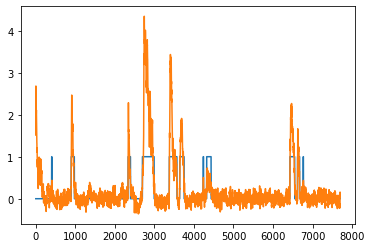

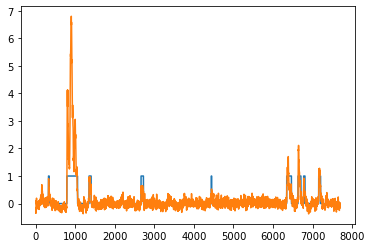

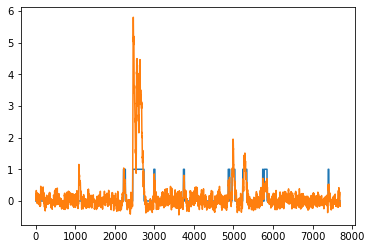

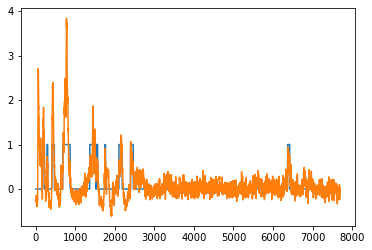

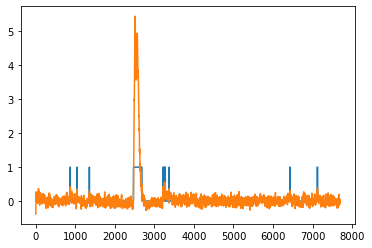

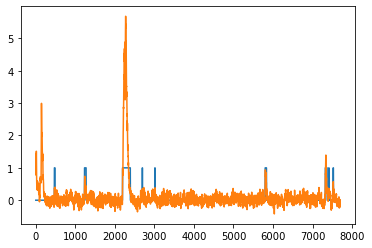

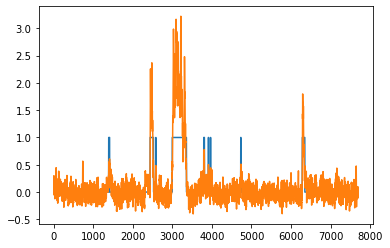

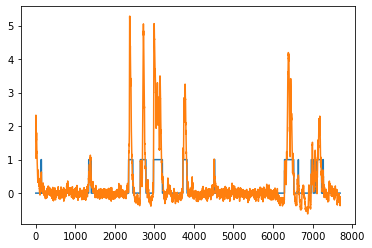

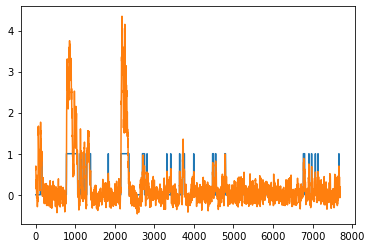

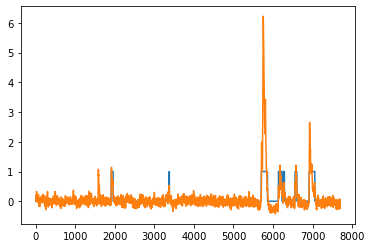

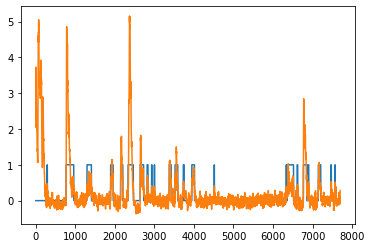

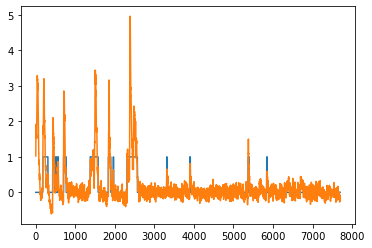

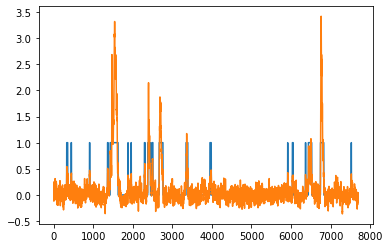

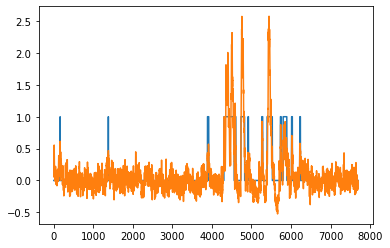

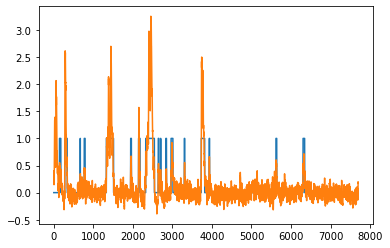

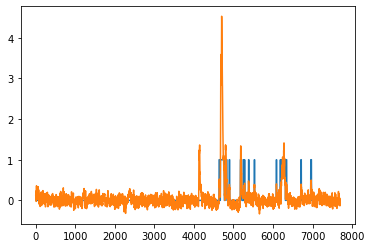

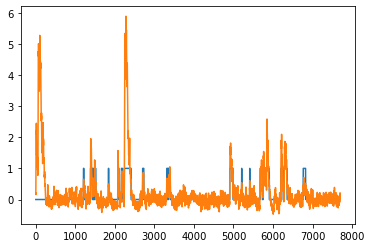

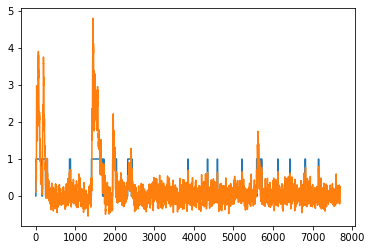

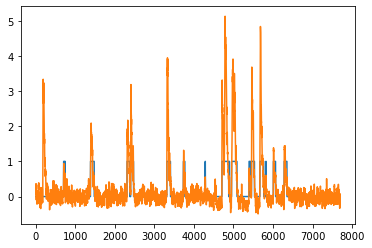

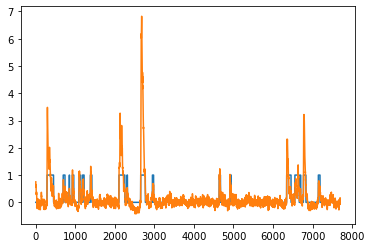

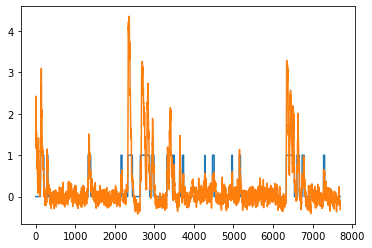

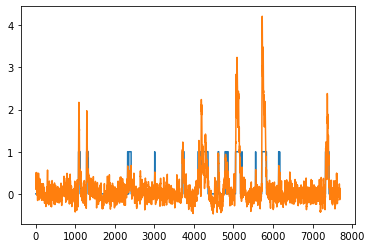

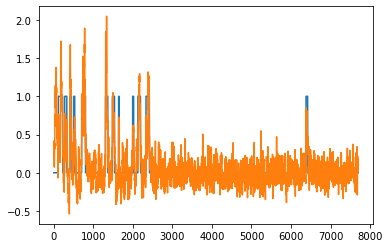

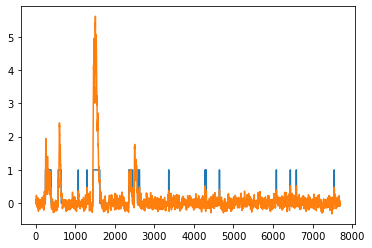

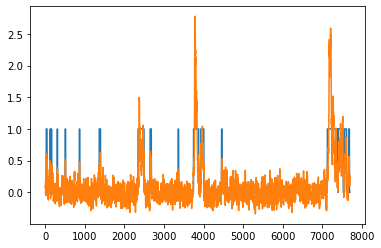

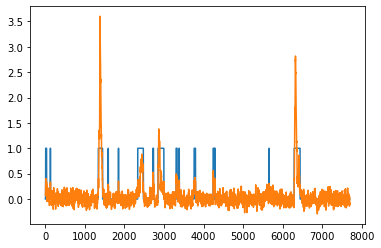

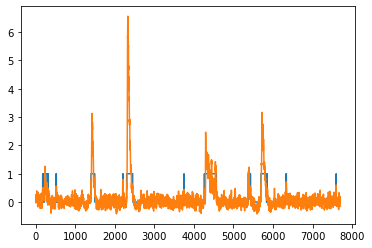

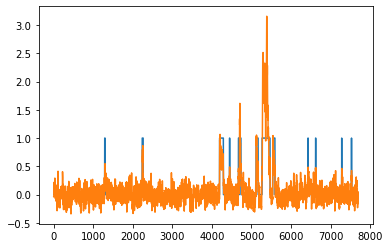

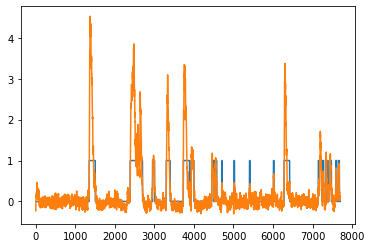

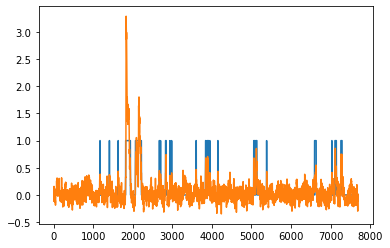

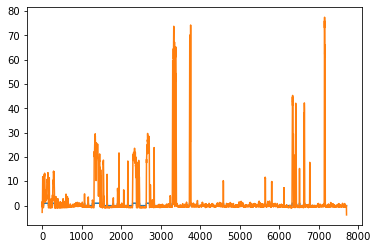

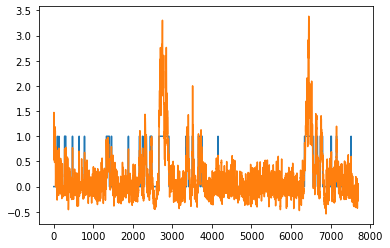

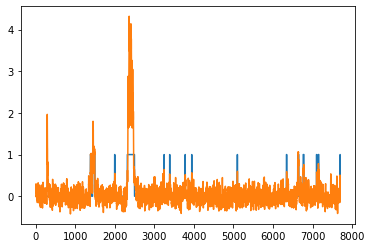

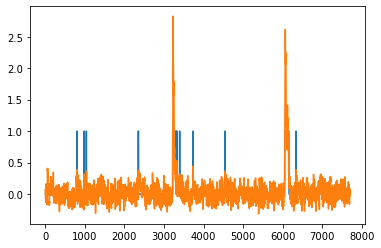

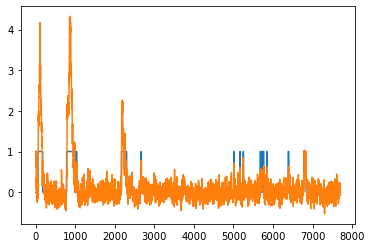

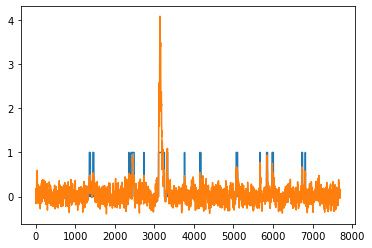

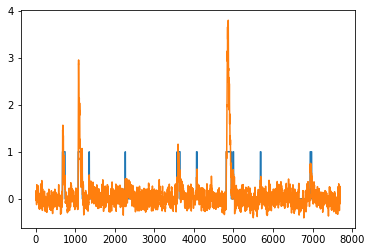

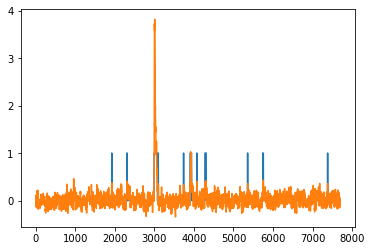

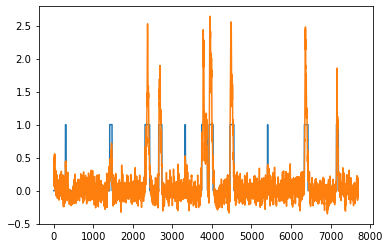

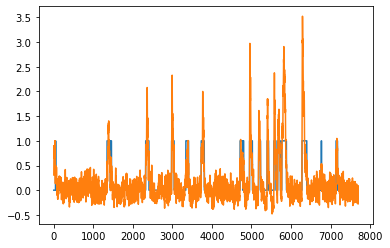

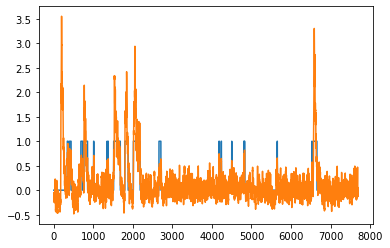

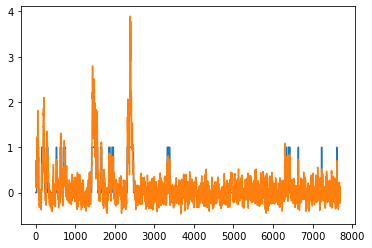

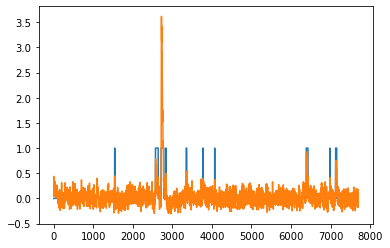

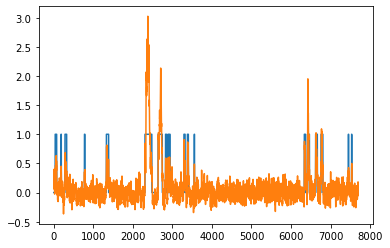

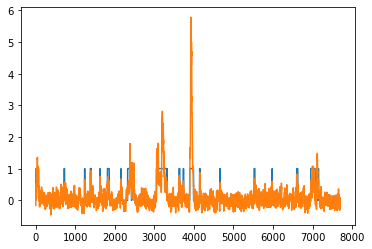

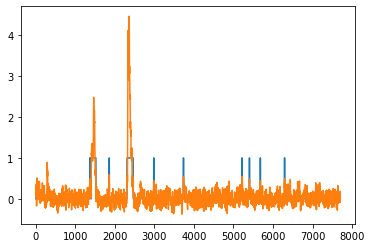

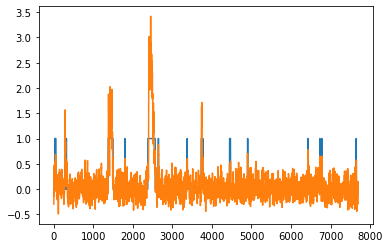

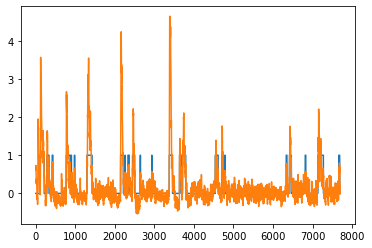

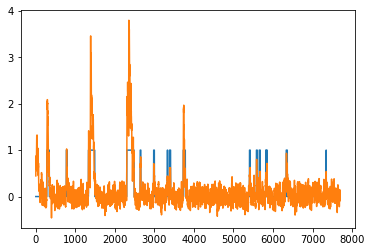

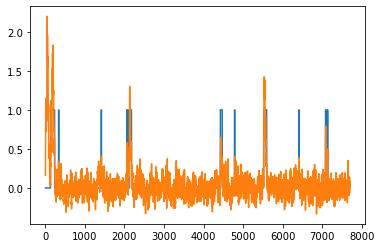

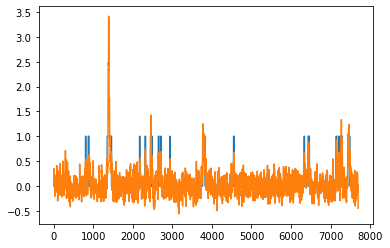

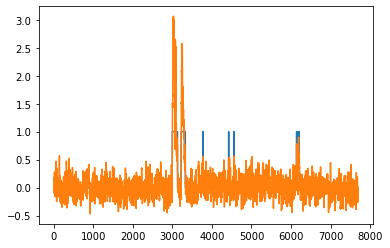

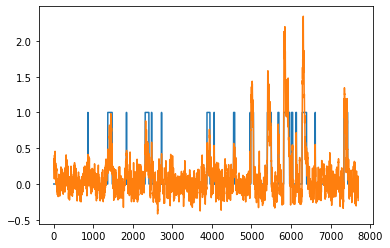

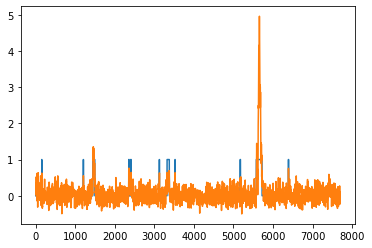

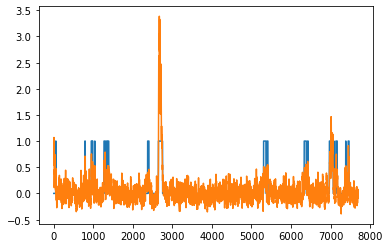

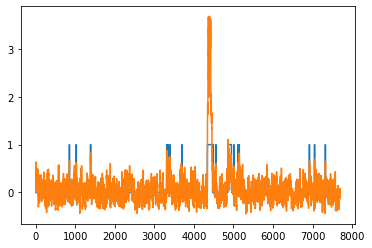

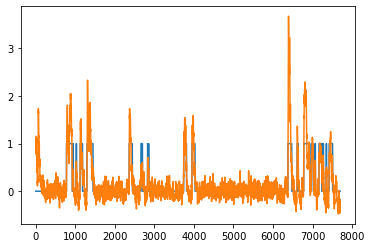

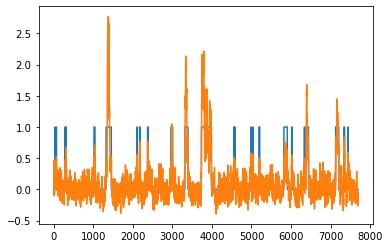

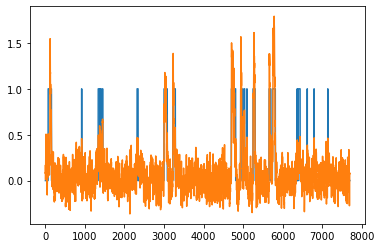

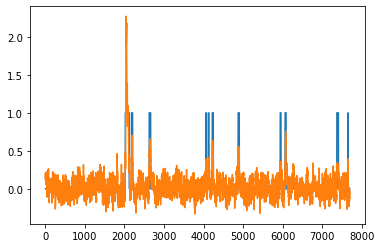

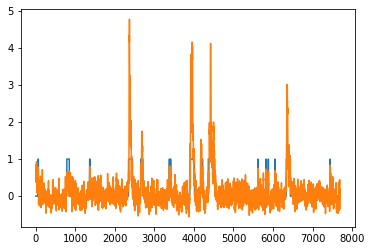

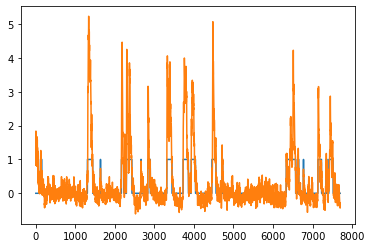

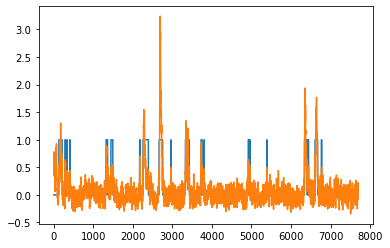

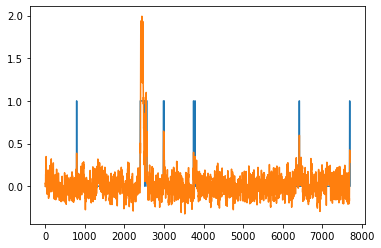

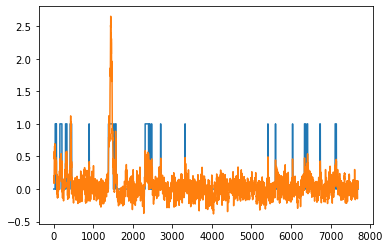

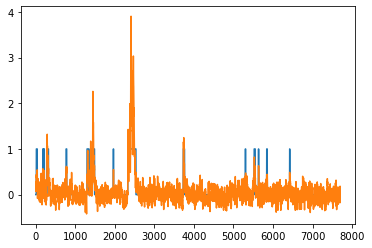

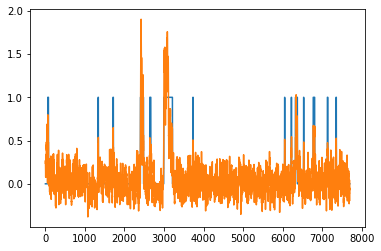

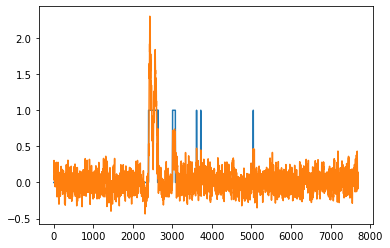

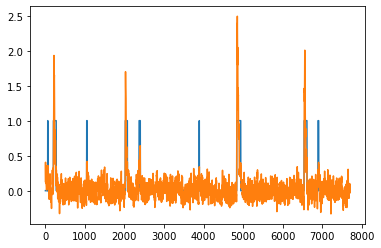

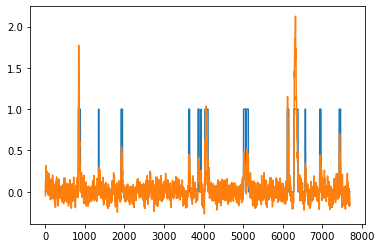

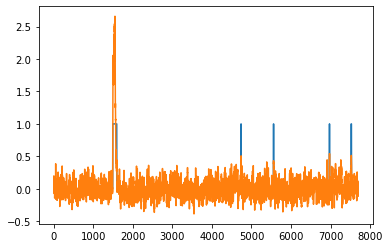

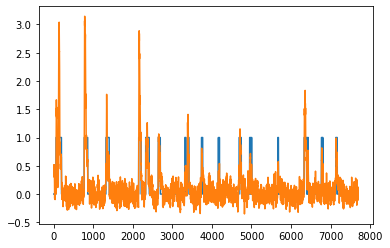

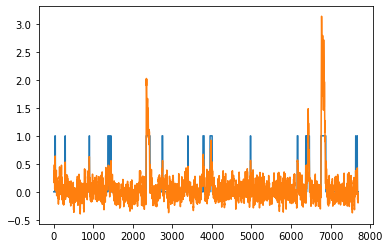

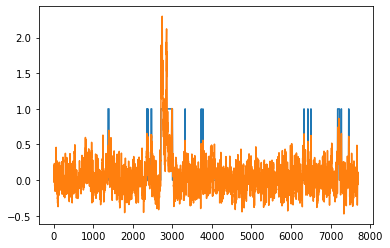

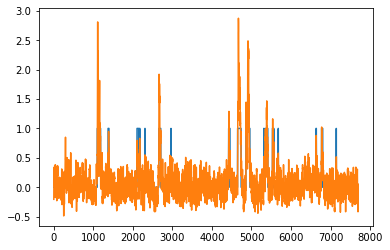

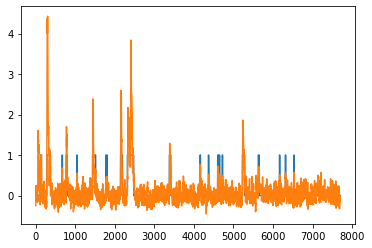

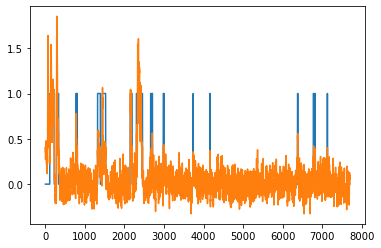

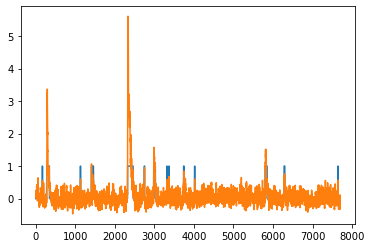

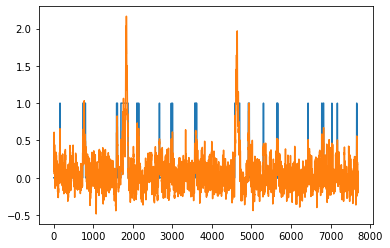

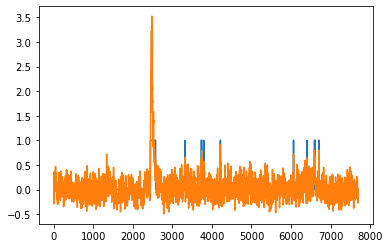

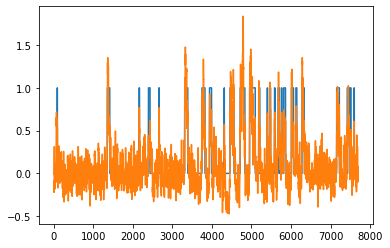

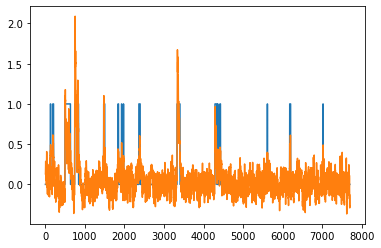

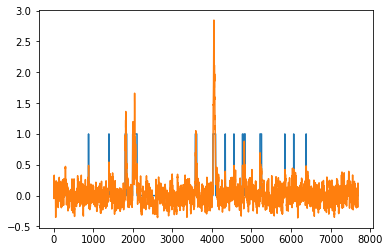

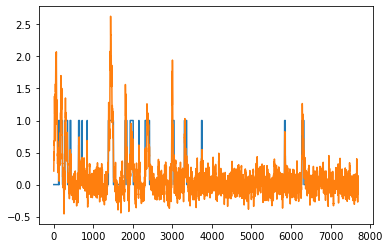

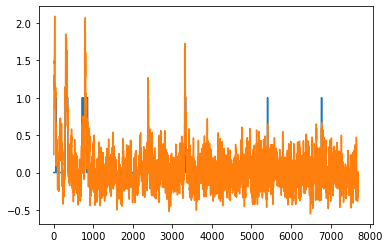

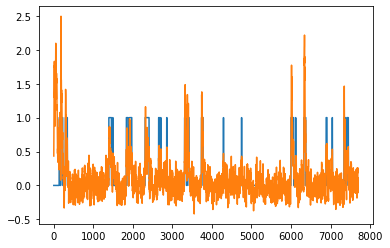

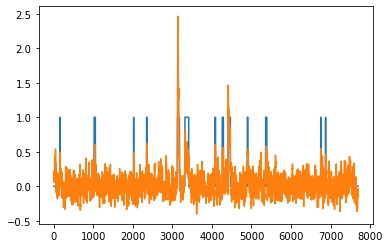

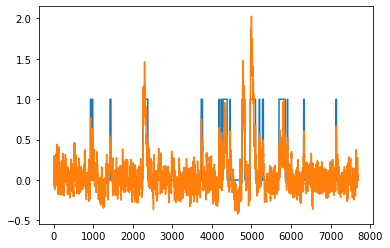

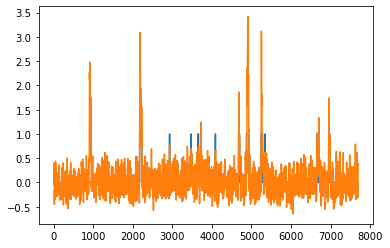

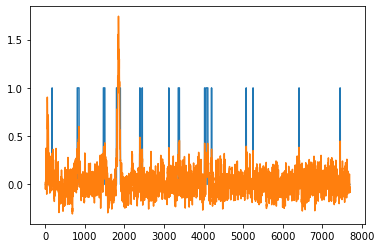

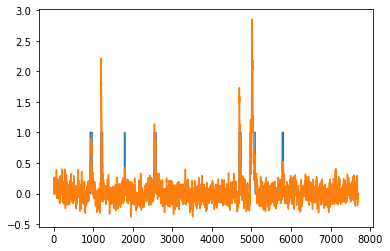

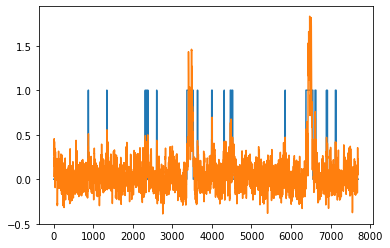

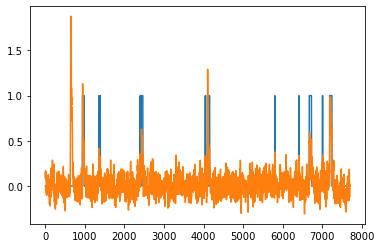

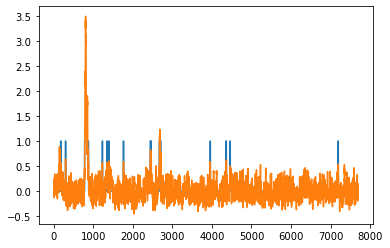

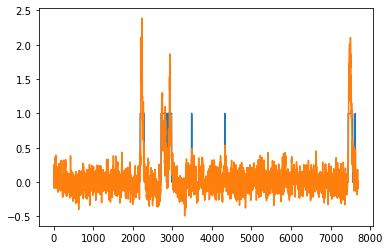

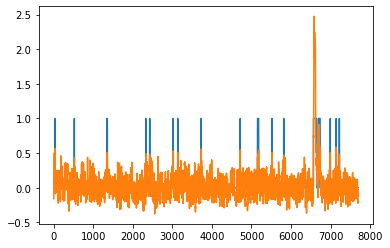

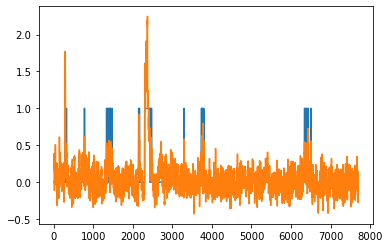

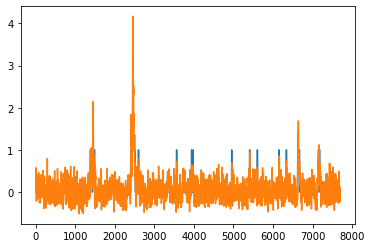

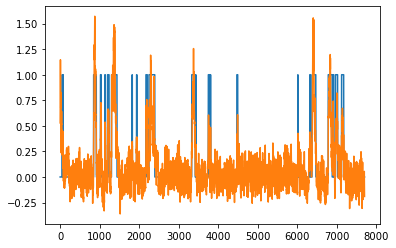

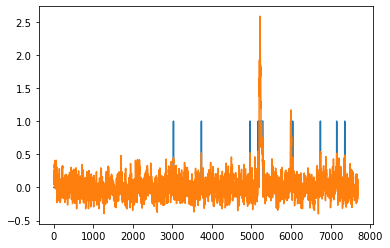

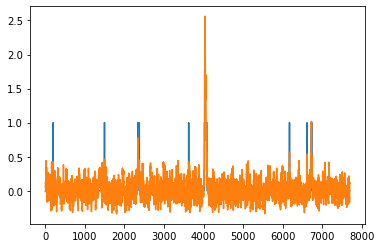

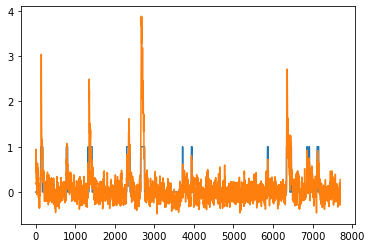

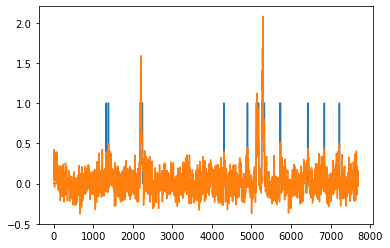

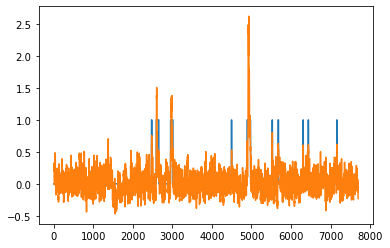

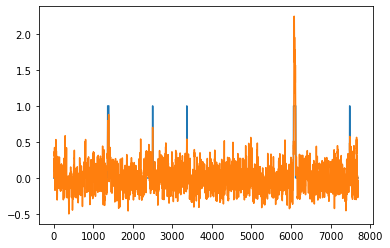

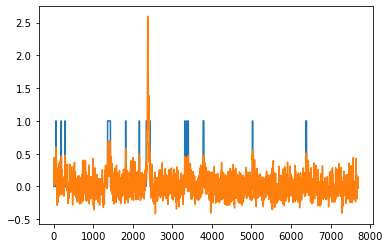

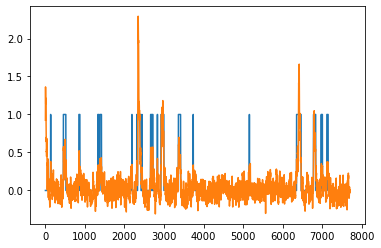

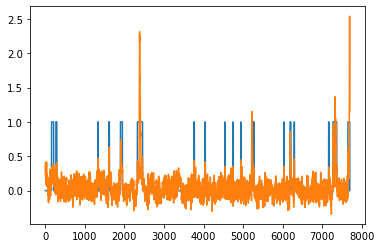

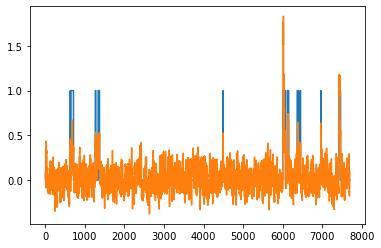

In [24]:
a, f, t = detection(new_dFoF, 3, 30)
for i in range(new_dFoF.shape[1]):
    plt.figure()
    plt.plot(a[:,i])
    plt.plot(new_dFoF[:,i])

In [ ]:
def downsample_avg(n, array1d):
    end =  n * int(len(array1d)/n)
    return np.mean(array1d[:end].reshape(-1, n), 1)
dFoF_ds = pd.DataFrame()
spikes_ds = pd.DataFrame()

for col in dFoF_df:
    dFoF_ds[col] = downsample_avg(3, np.asarray(dFoF_df[col]))
    spikes_ds[col] = downsample_avg(3, np.asarray(spikes_df[col]))

dFoF_z = utils.z_score(np.array(dFoF_ds))
spikes_z = utils.z_score(np.array(spikes_ds))

In [ ]:
a = 4
if not a%2:
    print("even")
else:
    print("odd")

In [ ]:
a = dFoF_z[:, 0]
std = np.nanstd(a)
inactive = np.nonzero(a < std*2)[0]
active = np.copy(a)
#active[inactive] = 0

plt.figure()
plt.plot(a)
b = np.copy(a)
b[inactive] = np.nan

plt.plot(b)
plt.ylim((-1,7))

active = np.split(active, 2)
frame_tracker = 0

for i in active:
    inactive = np.array(inactive) - frame_tracker
    ina = [x for x in inactive if x >0 and x <= len(i)]
    print(ina)
    c = np.copy(i)
    c[ina[:-1]] = 0
    d = i[ina[:-1]]
    plt.figure()
    plt.plot(i)
    plt.plot(c)
    plt.figure()
    plt.plot(d)
    frame_tracker = frame_tracker + len(i)

In [ ]:
for col in dFoF_ds.columns:
    plt.figure()
    plt.title(f"Cell {col + 1}")
    plt.plot(dFoF_z[:,col])
    plt.figure()
    plt.plot(spikes_z[:,col])

In [ ]:
import os
cells = [0,4,5,7,9,10,18,19,23,25,28,45]
save_path = r'C:\Users\Jake\Desktop\Figures\BRAIN_F32\Fig_1_General'

for cell in cells:
    plt.figure()
    plt.title(f'Cell {cell + 1}')
    plt.plot(spikes_z[cell])
    plt.ylim(bottom=-1, top=30)
    name = f'Cell_{cell + 1}'
    fname = os.path.join(save_path, name)
    fname = fname +'.pdf'
    #plt.savefig(fname)

In [ ]:
load_path = r'C:\Users\Jake\Desktop\Processed_data\python_data\JW070\220311'
fname = ['JW070_220311_Summary_dend1g', 'JW070_220311_Summary_dend1r']

data = load_pickle(fname, load_path)
spine_dFoF = data[0].Processed_dFoF
spine_activity = data[0].ActivityMap
dend_dFoF = data[1].Processed_Dendrite_dFoF
dend_activity = data[1].Dendrite_Binarized

In [ ]:
data[0]._fieldnames

In [ ]:
spine_dFoF_df = pd.DataFrame(spine_dFoF.T)
spine_activity_df = pd.DataFrame(spine_activity.T)
spine_dFoF_ds = pd.DataFrame()
dend_dFoF_df = pd.DataFrame(dend_dFoF.T)
dend_activity_df = pd.DataFrame(dend_activity.T)

for col in spine_dFoF_df:
    spine_dFoF_ds[col] = downsample_avg(6, np.asarray(spine_dFoF_df[col]))

dend_dFoF_ds = downsample_avg(6, np.asarray(dend_dFoF_df[0]))
dend_dFoF_ds = pd.DataFrame(dend_dFoF_ds)
#spine_dFoF_z = utils.z_score(spine_dFoF_ds)
#dend_dFoF_z = utils.z_score(dend_dFoF_ds)

In [ ]:
import copy
def get_active_inactive(dFoF, active):
    active_mask = (active == 1)
    inactive_mask = (active == 0)
    active_dFoF = np.copy(dFoF)
    inactive_dFoF = np.copy(dFoF)
    active_dFoF[active_mask] = np.nan
    inactive_dFoF[inactive_mask] = np.nan
    
    return active_dFoF, inactive_dFoF

In [ ]:
save_path = r'C:\Users\Jake\Desktop\Figures\BRAIN_F32\Fig_2_Dual'
for col in spine_dFoF_df.columns:
    active_dFoF, inactive_dFoF = get_active_inactive(spine_dFoF_df[col], spine_activity_df[col])
    plt.figure()
    plt.title(f"Cell {col + 1}")
    plt.plot(active_dFoF, color='blue')
    plt.plot(inactive_dFoF, color='red')
    plt.ylim(bottom=-0.5, top=1.5)
    plt.xticks(ticks=[0,600],labels=[0,600])
    name = f'Cell_{col + 1}'
    fname = os.path.join(save_path, name)
    fname = fname +'.pdf'
    plt.savefig(fname)
plt.figure()
dend_active, dend_inactive = get_active_inactive(dend_dFoF_df[0], dend_activity_df[0])
plt.title("Dendrite")
plt.plot(dend_active, color='blue')
plt.plot(dend_inactive, color='red')
name = 'Dendrite'
fname = os.path.join(save_path, name)
fname = fname + '.pdf'
#plt.savefig(fname)

In [ ]:
cells = {0:[4000,8000], 1:[0,4000],7:[4000,8000],10:[2000,6000], 21:[4000,8000], 26:[3000,7000]}
save_path = r'C:\Users\Jake\Desktop\Figures\BRAIN_F32\Fig_1_General'

for key, value in cells.items():
    print(value)
    plt.figure()
    plt.title(f'Cell {key + 1}')
    plt.plot(spine_dFoF_df[key].iloc[value[0]:value[1]])
    plt.ylim(bottom=-1, top=2.5)
    name = f'Cell_{key + 1}'
    fname = os.path.join(save_path, name)
    fname = fname +'.pdf'
    #plt.savefig(fname)

In [ ]:
total_21 = np.array([36,39,43,43,42,41,41,40,41,40,39,40,43,42])
new_21 = np.array([0,9,11,3,1,4,3,3,2,2,3,4,5,3])
elim_21 = np.array([0,6,6,3,2,5,3,4,1,3,4,3,2,4])

total_22 = np.array([34,36,29,29,31,29,27,28,20,31,32,33,33,32])
new_22 = np.array([0,5,0,3,4,4,3,2,2,2,3,3,2,1])
elim_22 = np.array([0,3,7,3,2,6,5,1,1,0,22,2,2,2])

total_22b = np.array([38,33,30,31,34,35,38,33,34,38,34,33,33,31])
new_22b = np.array([0,2,0,2,6,4,4,0,4,6,1,2,2,2])
elim_22b = np.array([0,7,3,1,3,2,1,5,3,2,5,3,2,4])

total_41 = np.array([40,39,44,46,47,46,46,45,45,40,39,41,42,42])
new_41 = np.array([0,2,6,2,3,2,3,0,1,0,2,2,1,1])
elim_41 = np.array([0,3,1,0,1,3,3,1,1,5,3,0,0,1])

total_41b = np.array([49,53,58,57,58,52,51,48,45,46,43,46,46,44])
new_41b = np.array([0,5,9,1,4,3,4,2,3,3,1,7,4,3])
elim_41b = np.array([0,1,4,2,3,9,3,5,6,2,4,4,4,1])

total_44 = np.array([90,83,83,85,84,83,84,86,84,83,83,87,84,86])
new_44 = np.array([0,3,6,4,4,5,3,6,2,3,5,6,1,4])
elim_44 = np.array([0,10,6,2,5,6,2,4,4,4,5,2,3,2])

In [ ]:
control_total = [total_21, total_41, total_41b]
control_new = [new_21, new_41, new_41b]
control_elim = [elim_21, elim_41, elim_41b]
gbp_total = [total_22, total_22b, total_44]
gbp_new = [new_22, new_22b, new_44]
gbp_elim = [elim_22, elim_22b, elim_44]

control_tot_norm = []
control_new_frac = []
control_elim_frac = []
for tot, new, elim in zip(control_total, control_new, control_elim):
    tot_norm = [x/tot[0] for x in tot]
    new_frac = [new[i]/tot[i] for i in range(len(new))]
    elim_frac = [-elim[a]/tot[a] for a in range(len(elim))]
    control_tot_norm.append(np.array(tot_norm))
    control_new_frac.append(np.array(new_frac))
    control_elim_frac.append(np.array(elim_frac))

    
gbp_tot_norm = []
gbp_new_frac = []
gbp_elim_frac = []
for tot, new, elim in zip(gbp_total, gbp_new, gbp_elim):
    tot_norm = [x/tot[0] for x in tot]
    new_frac = [new[i]/tot[i] for i in range(len(new))]
    elim_frac = [-elim[a]/tot[a] for a in range(len(elim))]
    gbp_tot_norm.append(np.array(tot_norm))
    gbp_new_frac.append(np.array(new_frac))
    gbp_elim_frac.append(np.array(elim_frac))

In [ ]:
from scipy import stats
control_tot_mean = np.mean(control_tot_norm, axis=0)
control_tot_sem = stats.sem(control_tot_norm, axis=0)
control_new_mean = np.mean(control_new_frac, axis=0)
control_new_sem = stats.sem(control_new_frac, axis=0)
control_elim_mean = np.mean(control_elim_frac, axis=0)
control_elim_sem = stats.sem(control_elim_frac, axis=0)

gbp_tot_mean = np.mean(gbp_tot_norm, axis=0)
gbp_tot_sem = stats.sem(gbp_tot_norm, axis=0)
gbp_new_mean = np.mean(gbp_new_frac, axis=0)
gbp_new_sem = stats.sem(gbp_new_frac, axis=0)
gbp_elim_mean = np.mean(gbp_elim_frac, axis=0)
gbp_elim_sem = stats.sem(gbp_elim_frac, axis=0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
path =  r'C:\Users\Jake\Desktop\Figures'
fig = plt.figure(figsize=(7,5))
fig.suptitle("Normalized Spine Density")
sessions = [x+1 for x in range(len(control_tot_mean))]
plt.errorbar(sessions, control_tot_mean, yerr=control_tot_sem, color="black", marker="o", markerfacecolor="white", markeredgecolor='black',
            linewidth=1.5, elinewidth=0.8, ecolor="black")
plt.errorbar(sessions, gbp_tot_mean, yerr=gbp_tot_sem, color="red", marker="o", markerfacecolor="white", markeredgecolor='red',
            linewidth=1.5, elinewidth=0.8, ecolor="red")
plt.xlabel("Session", labelpad=15)
plt.ylabel("Spine Density (Norm.)", labelpad=15)
plt.ylim(bottom=0.7, top = 1.3)
plt.axhline(y=1.0, color="black", linestyle="--")
fig.tight_layout()
fname = os.path.join(path, 'spine_density.pdf')
plt.savefig(fname)

In [ ]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("Control Spine Dynamics")

plt.bar(sessions, height=control_new_mean, yerr=control_new_sem,color="black")
plt.bar(sessions, height=control_elim_mean, yerr=control_elim_sem, color="black")
plt.axhline(y=0, color="black", linestyle="-")
plt.xlabel("Session", labelpad=15)
plt.ylabel("Spine Dynamics (frac.)", labelpad=15)
plt.ylim(bottom=-.25, top = .25)
fig.tight_layout()
fname = os.path.join(path, 'ctl_dynamics.pdf')
plt.savefig(fname)

In [ ]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("GBP Spine Dynamics")

plt.bar(sessions, height=gbp_new_mean, yerr=gbp_new_sem,color="red")
plt.bar(sessions, height=gbp_elim_mean, yerr=gbp_elim_sem, color="red")
plt.axhline(y=0, color="black", linestyle="-")
plt.xlabel("Session", labelpad=15)
plt.ylabel("Spine Dynamics (frac.)", labelpad=15)
plt.ylim(bottom=-.25, top = .25)
fig.tight_layout()
fname = os.path.join(path, 'gbp_dynamics.pdf')
plt.savefig(fname)